In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import math

# set seed 
torch.manual_seed(42)
np.random.seed(42)

## Transformers and Attention Mechanism

In this lab, we will explore the core components of the Transformer model, which has revolutionized natural language processing and sequence modeling. The Transformer model, introduced by Vaswani et al. in 2017 (https://arxiv.org/pdf/1706.03762).

By the end of this exercise, you will have a solid grasp of how each part of the Transformer contributes to its success, and how attention mechanisms allow it to focus on relevant parts of an input sequence when making predictions. 

![transformer_encoder.png](images/transformer_encoder.png)

### Creating a Synthetic Time Series Dataset with Jumps


In this section, we define a **custom dataset class** that generates synthetic time series data with jumps at regular intervals. This class, `TimeSeriesDataset`, is designed to simulate a flat time series with pseudorandom spikes introduced at specific points. 
Each time series begins as a flat line and has a jump introduced at a random point within the first few time steps. Additional jumps occur at regular intervals, alternating between small and large jumps.

In [2]:
# Create a Synthetic Time Series Dataset (Flat with jumps)
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, seq_len, num_samples):
        val = 3
        initial_jump = 5 

        self.seq_len = seq_len
        self.data = []
        for _ in range(num_samples):
            time_series = np.zeros(seq_len + 1)
            
            # Introduce the first jump at a random point between 0 and val
            first_jump = np.random.randint(0, val)
            time_series[first_jump] += np.random.rand() + initial_jump  # Add a jump with some noise
            
            # Continue to introduce jumps every val timesteps after the first jump
            for i in range(first_jump + val, seq_len + 1, val):
                jump = 0 if i % 2 == 1 else initial_jump # Alternate between 0 and initial_jump
                time_series[i] += np.random.rand() + jump  # Add a jump with some noise
            
            self.data.append(time_series)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        series = self.data[idx]
        return torch.tensor(series[:-1], dtype=torch.float32), torch.tensor(series[-1], dtype=torch.float32)

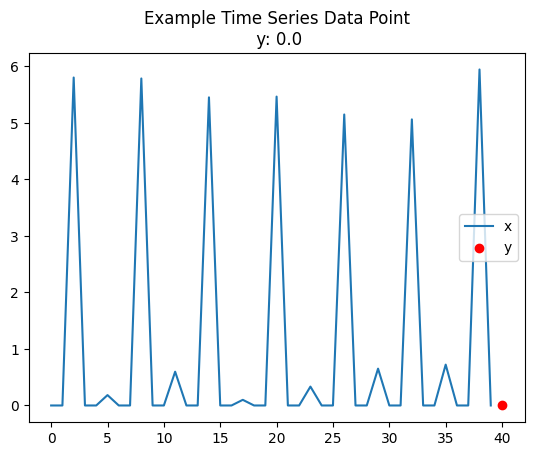

In [3]:
# show a sample of the dataset

dataset = TimeSeriesDataset(seq_len=40, num_samples=1)
x, y = dataset[0]
plt.plot(range(40), x, label='x')
plt.title(f"Example Time Series Data Point\n y: {y}")
plt.scatter(40, y, color='r', label='y')
plt.legend()
plt.show()

### The Attention Mechanism

The attention mechanism allows the model to weigh the importance of different parts of the input sequence relative to each other. In the **Self-Attention** mechanism, each word in the input is compared to every other word to determine their relevance.

The attention mechanism is mathematically defined as:

$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$

Where:
- $ Q $ is the query matrix
- $ K $ is the key matrix
- $ V $ is the value matrix
- $ d_k $ is the dimensionality of the keys

### Scaled Dot-Product Attention Mechanism

The attention mechanism operates in the following steps:

- **Score Calculation**: The attention scores are calculated by taking the dot product between the query and the transposed key matrices. This operation measures how relevant each position in the key is to the query. The scores are scaled by the square root of the dimensionality of the key (`d_k`) to avoid large gradients, which could destabilize the training process.

- **Relative Positional Encoding**: In addition to the attention scores, we add learnable **relative positional encodings** to capture the relationships between elements in the sequence. This encoding helps the model understand the relative positions of tokens without relying solely on absolute positional information. The relative encodings are stored in a learnable layer, which is added to the attention scores before applying softmax. If another type of positional encoding is present, this step is skipped.

- **Masking (Optional)**: If a mask is provided, it is applied to the scores by setting specific elements to a very large negative value. This prevents the model from attending to certain positions, which is particularly useful when handling padded sequences in time series or natural language tasks. For this particular problem the mask is not required, so it is not present in the implementation.

- **Softmax**: After computing the scaled scores, the softmax function is applied to normalize the scores into probabilities. This step ensures that the attention weights sum to 1 across each sequence position, allowing the model to attend to specific parts of the input more heavily.

- **Attention Output**: Finally, the attention weights are used to compute a weighted sum of the value matrix, generating the output. This allows the model to focus on important information in the sequence and ignore less relevant parts.

The attention mechanism returns both the final output and the attention weights, providing insight into which parts of the input the model is focusing on.


In [4]:
import torch
import torch.nn as nn

# Define the Scaled Dot-Product Attention Mechanism
class ScaledDotProductAttention(nn.Module):
    def __init__(self, seq_len, d_k, other_positional_encodings_present):
        super(ScaledDotProductAttention, self).__init__()

        self.d_k = d_k
        self.seq_len = seq_len
        self.other_positional_encodings_present = other_positional_encodings_present

        self.rel_layer = torch.randn(1, self.seq_len, self.seq_len, requires_grad=True) # Create a learnable relative positional encoding

    def forward(self, query, key, value):
        # Compute the attention scores
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32)) # Scaled Dot-Product
        
        # Add relative positional encodings if no other positional encodings are present
        if not self.other_positional_encodings_present:
            scores = scores + self.rel_layer
        
        # Compute the attention weights
        attention_weights = torch.softmax(scores, dim=-1)
        
        # Compute the output
        output = torch.matmul(attention_weights, value)
        
        return output, attention_weights

### Attention Head

The attention head encapsulates the `ScaledDotProductAttention` mechanism by preparing the query, key, and value through linear layers. After computing attention, the result is passed through a final linear layer.

In [5]:
class AttentionHead(nn.Module):
    def __init__(self, d_model, seq_len, other_positional_encodings_present):
        super(AttentionHead, self).__init__()
        self.d_k = d_model
        self.seq_len = seq_len

        # Define linear layers for query, key, and value
        self.query_layer = nn.Linear(d_model, d_model)
        self.key_layer = nn.Linear(d_model, d_model)
        self.value_layer = nn.Linear(d_model, d_model)

        # Scaled dot-product attention
        self.scaled_dot_attention = ScaledDotProductAttention(self.seq_len, self.d_k, other_positional_encodings_present)

        # Output linear layer
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value):
                
        # Apply linear layers to query, key, value
        Q = self.query_layer(query)
        K = self.key_layer(key)
        V = self.value_layer(value)

        # Apply scaled dot-product attention
        attention_output, attention_weights = self.scaled_dot_attention(Q, K, V)

        attention_output = attention_output.squeeze(1)       
        output = self.fc_out(attention_output)

        return output, attention_weights

### Transformer Encoder Block

The **Transformer Encoder Block** is a fundamental building block of the Transformer architecture, used to process input sequences by combining attention mechanisms and feed-forward networks. The block consists of two primary sublayers:

1. **Attention Head**: The input sequence is passed through the **AttentionHead**, which computes the scaled dot-product attention by projecting the query, key, and value matrices using linear layers. The attention output is then combined with the original input through a residual connection and normalized using **LayerNorm**.

2. **Feed-Forward Network (FFN)**: After the attention sublayer, the normalized output is passed through a feed-forward network consisting of two linear layers with a ReLU activation function. The first linear layer expands the dimensionality of the input, and the second linear layer projects it back to the original dimension.

By stacking multiple encoder blocks, the Transformer model is able to build hierarchical representations of the input, allowing it to capture complex relationships and patterns in the data.

In [6]:
# Define a basic Transformer Encoder block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, dim_feedforward, seq_len, other_positional_encodings_present, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = AttentionHead(d_model, seq_len, other_positional_encodings_present)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Attention head
        attention_output, attention_weights = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attention_output))

        # Feed-forward network
        ffn_output = self.ffn(x)
        output = self.norm2(x + self.dropout(ffn_output))

        return output, attention_weights

### Transformer Model for Time Series

Finally the **Transformer Model** designed for time series data is implemented. Below are the key components of the model:

1. **Embedding Layer**: The input time series is first passed through a linear embedding layer that projects the input features into a higher-dimensional space (`d_model`). This transformation enables the model to work with rich feature representations of the input data.

2. **Positional Encoding**: Since the Transformer does not inherently capture the order of the input sequence, positional encodings are added to provide information about the position of each time step in the sequence. If a positional encoding method is provided, it is applied to the embedded input. Otherwise, the **Relative Positional Encoding** provided in `ScaledDotProductAttention` is applied.

3. **Transformer Encoder Layers**: The model contains `num_layers` **TransformerEncoderBlocks**, which apply both attention mechanisms and feed-forward networks to the input sequence. These encoder layers are stacked to progressively build hierarchical representations of the input data. Each layer outputs attention weights, which provide insight into which parts of the sequence the model is focusing on.

4. **Output Layer**: After processing the input through the encoder layers, the model applies a final linear layer to predict the output. For time series regression tasks, the model uses the output from the last time step in the sequence to generate a single value.

Throughout the forward pass, attention weights from each encoder layer are collected. These weights can be used for interpretability, showing how the model distributes its focus across the input sequence.

In [7]:
# Define a simple Transformer Model
class Transformer(nn.Module):
    def __init__(self, input_size, d_model, dim_feedforward, num_layers, seq_len, positional_encoding = None, dropout=0.1, max_len=5000):
        super(Transformer, self).__init__()

        self.positional_encoding = positional_encoding

        # Embedding for the time series input
        self.embedding = nn.Linear(input_size, d_model)
        
        # Positional encoding for time series data
        if self.positional_encoding is not None:
            self.pos_encoder = self.positional_encoding(d_model, max_len)
        
        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderBlock(d_model, dim_feedforward, seq_len, False if positional_encoding is None else True, dropout) for _ in range(num_layers)]
        )
        
        # Output layer to predict a single value
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]
        
        # Embed the input time series data
        x = self.embedding(x)  # Shape: [batch_size, seq_len, d_model]    
        
        # Add positional encoding
        x = self.pos_encoder(x) if self.positional_encoding is not None else x
        
        # List to store attention weights from all layers
        all_attention_weights = []

        # Pass through each Transformer encoder layer
        for layer in self.encoder_layers:
            x, attention_weights = layer(x)
            all_attention_weights.append(attention_weights)

        # Apply final linear layer to get the output
        output = self.fc_out(x[:, -1])  # Take the output of the last time step (sequence regression)
        return output, all_attention_weights  # Return the final output and the attention weights

In [8]:
input_size = 1  # Number of input features
seq_len = 40 # Length of the time series sequence

d_model = 64  # Embedding dimension
dim_feedforward = 256  # Feedforward network dimension
num_layers = 3  # Number of Transformer encoder layers

model = Transformer(input_size, d_model, dim_feedforward, num_layers, seq_len)


In [9]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, target in dataloader:
            inputs = inputs.unsqueeze(2)  # Add feature dimension (batch_size, seq_len, input_size)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs.squeeze(), target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')
    
    # Plot the loss history
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.show()

In [10]:
batch_size = 128 # Number of samples in each batch
num_samples = 1000 # Number of samples in the dataset
num_epochs = 15 # Number of training epochs

Epoch 1/15, Loss: 7.427663743495941
Epoch 2/15, Loss: 5.983713805675507
Epoch 3/15, Loss: 5.036113440990448
Epoch 4/15, Loss: 4.190215229988098
Epoch 5/15, Loss: 2.872079163789749
Epoch 6/15, Loss: 1.5474531725049019
Epoch 7/15, Loss: 0.5640905275940895
Epoch 8/15, Loss: 0.260670755058527
Epoch 9/15, Loss: 0.16971065755933523
Epoch 10/15, Loss: 0.07864227658137679
Epoch 11/15, Loss: 0.054104790557175875
Epoch 12/15, Loss: 0.04324177512899041
Epoch 13/15, Loss: 0.03813578491099179
Epoch 14/15, Loss: 0.03645165404304862
Epoch 15/15, Loss: 0.035582763608545065


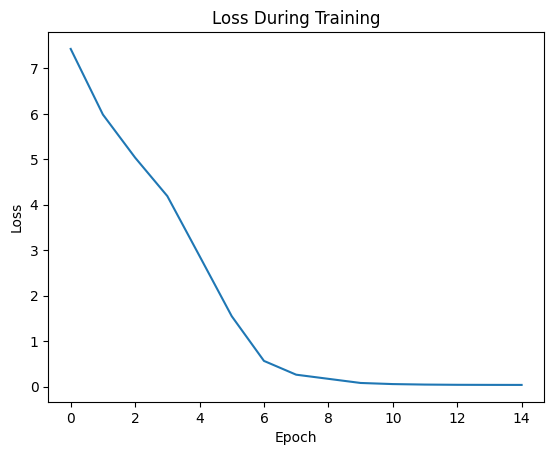

In [11]:
# Initialize the DataLoader
dataset = TimeSeriesDataset(seq_len, num_samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs=num_epochs)

### Visualization of Normalized Attention Weights

This plot displays the **Input Series** (blue line) along with the corresponding **Normalized Attention Weights** (orange dashed line). The normalized attention weights highlight the time steps that the Transformer model focuses on during the prediction process.

What's interesting is how the model places more attention on previous jumps in the sequence. These small spikes in the attention weights indicate that the model is focusing on key points in the input that help it make a more accurate prediction. The red dot marks the **true target value** (5.51), and the green dot shows the **predicted value** (5.63). The fact that the predicted value is so close to the true target demonstrates how well the model is learning from the input data.

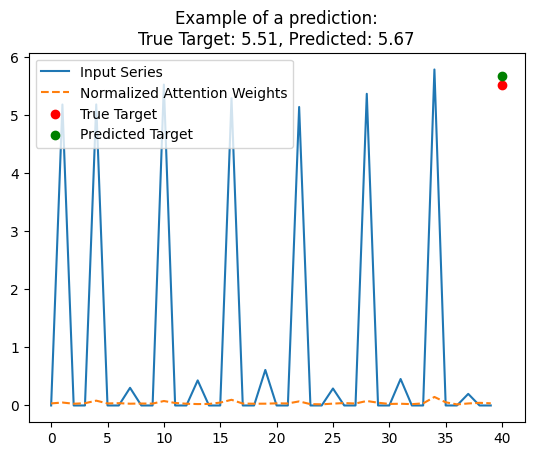

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Visualize the Attention Weights
def visualize_attention(model, dataset):
    model.eval()
    for i in range(len(dataset)):
        inputs, target = dataset[i]
        if target != 0: 
            # Reshape the input for the Transformer: [batch_size, seq_len, input_size]
            inputs = inputs.unsqueeze(0).unsqueeze(2)
            outputs, attention_weights = model(inputs)
            break

    # Plot the input time series (after undoing the batch and input dimension)
    plt.plot(inputs.permute(1, 0, 2).squeeze().numpy(), label="Input Series")

    # The attention weights are returned from all layers, so let's use the attention from the last layer
    attention_weights = attention_weights[-1][0].detach().numpy()  # [batch_size, num_heads, seq_len, seq_len]

    # Normalize attention weights for better visibility
    normalized_attention_weights = (attention_weights - np.min(attention_weights)) / (np.max(attention_weights) - np.min(attention_weights))
    
    
    # Plot the normalized attention weights
    plt.plot(normalized_attention_weights.mean(axis=0), label="Normalized Attention Weights", linestyle='--')
    plt.scatter(seq_len, target, color='r', label='True Target')
    plt.scatter(seq_len, outputs[-1].item(), color='g', label='Predicted Target')
    plt.title(f"Example of a prediction:\nTrue Target: {target.item():.2f}, Predicted: {outputs[-1].item():.2f}")
    plt.legend(loc='upper left')
    plt.show()



visualize_attention(model, dataset)

### Importance of Relative Positional Encoding

In standard Transformer architectures, **absolute positional encodings** are commonly used to inject information about the position of each token or time step into the model. This works well for tasks where the exact position of each element in the sequence is critical. However, for many time series and sequence-based datasets, the **relative position** between elements often carries more significance than their absolute position. This is where **relative positional encoding** becomes crucial.

In this model, **relative positional encoding** is applied due to the specific nature of the dataset, where the height of each jump depends on the previous one, and jumps occur consistently every `val = 3` timesteps. The dataset contains strong temporal dependencies, making it vital for the model to assess the relative distance between events, regardless of their absolute position. Additionally, since the jumps are shifted between the different time series in the dataset, the model must capture these relationships in a way that generalizes across varying time series sequences.

### Comparison Between Absolute and Relative Positional Encodings

The **PositionalEncoding** class shown below implements absolute positional encoding, where each position in the sequence is encoded using a combination of sine and cosine functions. This encoding is then added to the input embeddings to provide the model with information about the position of each token in the sequence. Here’s how the code works:

- **Matrix Creation**: A positional encoding matrix `pe` of shape `(max_len, d_model)` is initialized, where `max_len` is the maximum sequence length and `d_model` is the dimensionality of the model.
- **Position Calculation**: The `position` tensor is created, holding the position values for each token in the sequence. The `div_term` tensor calculates the scaling factor for the sine and cosine functions based on the position and the model’s dimensionality.
- **Sine and Cosine Application**: The sine function is applied to the even indices, and the cosine function is applied to the odd indices of the positional encoding matrix. This ensures that each position has a unique encoding based on a combination of sine and cosine functions.
- **Buffer Registration**: The positional encoding matrix `pe` is registered as a buffer, meaning it is a fixed parameter that does not get updated during backpropagation.
- **Forward Pass**: During the forward pass, the positional encoding is added to the input, giving the model information about the absolute positions of each token in the sequence.


In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create a matrix of shape (max_len, d_model) to hold the positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Compute sine and cosine positional encodings
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sine to even indices in the encoding
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cosine to odd indices in the encoding
        
        pe = pe.unsqueeze(0).transpose(0, 1)  # Reshape for batch compatibility
        self.register_buffer('pe', pe)  # Register pe as a buffer so it doesn't get updated during backpropagation

    def forward(self, x):
        # Add positional encoding to the input
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

Epoch 1/15, Loss: 7.021695613861084
Epoch 2/15, Loss: 6.362592101097107
Epoch 3/15, Loss: 6.100487470626831
Epoch 4/15, Loss: 5.7810046672821045
Epoch 5/15, Loss: 5.833798766136169
Epoch 6/15, Loss: 5.7214608788490295
Epoch 7/15, Loss: 5.693623661994934
Epoch 8/15, Loss: 5.6319133043289185
Epoch 9/15, Loss: 5.6482744216918945
Epoch 10/15, Loss: 5.514361202716827
Epoch 11/15, Loss: 5.497169256210327
Epoch 12/15, Loss: 5.466455459594727
Epoch 13/15, Loss: 5.330662250518799
Epoch 14/15, Loss: 5.266856372356415
Epoch 15/15, Loss: 5.3509268164634705


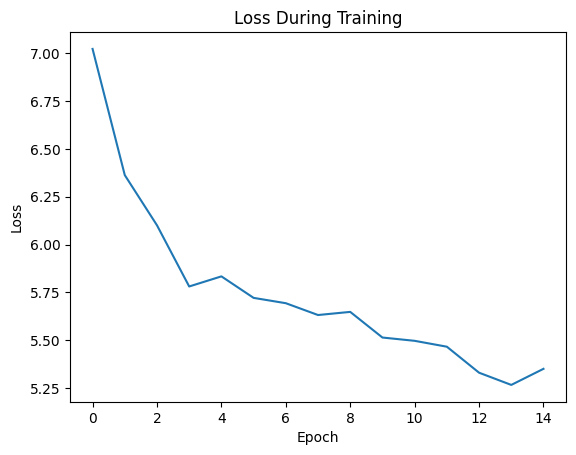

In [14]:
model = Transformer(input_size, d_model, dim_feedforward, num_layers, seq_len, PositionalEncoding)

# Instantiate the criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs=num_epochs)

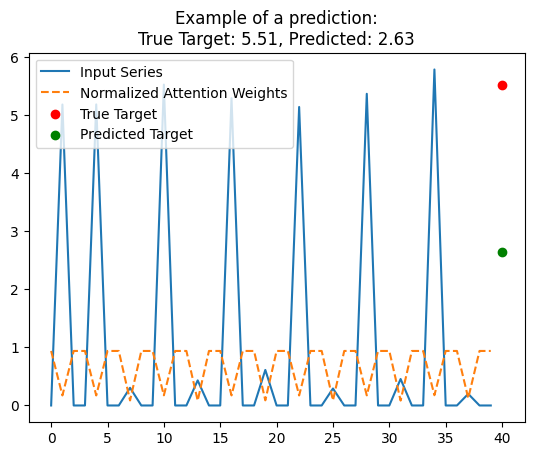

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Visualize the Attention Weights
def visualize_attention(model, dataset):
    model.eval()
    for i in range(len(dataset)):
        inputs, target = dataset[i]
        if target != 0: 
            # Reshape the input for the Transformer: [batch_size, seq_len, input_size]
            inputs = inputs.unsqueeze(0).unsqueeze(2)
            outputs, attention_weights = model(inputs)
            break

    # Plot the input time series (after undoing the batch and input dimension)
    plt.plot(inputs.permute(1, 0, 2).squeeze().numpy(), label="Input Series")

    # The attention weights are returned from all layers, so let's use the attention from the last layer
    attention_weights = attention_weights[-1][0].detach().numpy()  # [batch_size, num_heads, seq_len, seq_len]

    # Normalize attention weights for better visibility
    normalized_attention_weights = (attention_weights - np.min(attention_weights)) / (np.max(attention_weights) - np.min(attention_weights))
    
    
    # Plot the normalized attention weights
    plt.plot(normalized_attention_weights.mean(axis=0), label="Normalized Attention Weights", linestyle='--')
    plt.scatter(seq_len, target, color='r', label='True Target')
    plt.scatter(seq_len, outputs[-1].item(), color='g', label='Predicted Target')
    plt.title(f"Example of a prediction:\nTrue Target: {target.item():.2f}, Predicted: {outputs[-1].item():.2f}")
    plt.legend(loc='upper left')
    plt.show()



visualize_attention(model, dataset)

The key observation from this experiment is that the model using absolute positional encoding performed significantly worse than the one using relative positional encoding. This performance difference highlights the fact that, in this particular dataset, the **relative position** between events is much more important than their absolute position. Since the jumps in the dataset occur at fixed intervals (`val = 3` timesteps) but are shifted between different time series, the model must capture the relationships between events based on their distances, which is effectively handled by relative positional encodings. Absolute positional encodings, on the other hand, can't capture these relative relationships, leading to poorer model performance.